In [1]:

# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns


#  Modelado y métricas
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score , cohen_kappa_score, roc_curve,roc_auc_score


#  Gestión de warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

# Pair Programming Métricas

### Ana Gonzalez y Ana Campos

En el ejercicio de pair programming anterior ajustastéis vuestro primer modelito de regresión logística. Ahora es el momento de saber como de bueno es nuestro modelo. Para esto, los objetivos del pair de hoy son:
- Calculad las métricas para vuestro modelo
- Interpretad las métricas obtenidas, ¿es un buen modelo? ¿hay overfitting o underfitting?

In [ ]:
df_noesta_nobal = pd.read_pickle("../data-log/02-df_codifcadas_no_estandarizadas.pickle")
df_noesta_nobal.head()


In [ ]:
df_noesta_nobal.drop('id', axis=1,inplace=True)

In [ ]:
df_est_nobal = pd.read_pickle("../data-log/02-df_estandarizadas_codificadas.pickle")
df_est_nobal.head()

,id,sex,education,is_smoking,BPMeds,prevalentStroke,prevalentHyp,diabetes,TenYearCHD,age,cigsPerDay,glucose,totChol,sysBP,diaBP,BMI,heartRate
0,0.0,1,2.0,1,0.0,0.0,0.0,0.0,1.0,1.071429,0.15,0.153846,-0.224138,0.722222,0.193548,0.136595,1.000000
1,2.0,1,1.0,1,0.0,0.0,0.0,0.0,0.0,-0.214286,0.50,1.230769,0.275862,-0.462963,-0.709677,-1.009027,0.866667
2,4.0,1,1.0,1,0.0,0.0,0.0,0.0,0.0,1.071429,1.50,-0.076923,0.120690,0.296296,0.193548,0.208626,-0.333333
3,7.0,0,4.0,1,0.0,0.0,0.0,0.0,0.0,-0.928571,1.75,-1.153846,1.051724,-0.981481,-0.903226,0.555667,-1.000000
4,8.0,1,2.0,1,0.0,0.0,0.0,0.0,0.0,-0.571429,1.00,0.076923,-0.241379,-0.092593,-0.258065,-0.938816,0.733333


In [ ]:
df_est_nobal.drop('id', axis=1,inplace=True)

In [ ]:
df_est_cod_bal=pd.read_pickle('../data-log/02-bal_est_cod.pickle')
df_est_cod_bal.head(2)

,sex,education,is_smoking,BPMeds,prevalentStroke,prevalentHyp,diabetes,age,cigsPerDay,glucose,totChol,sysBP,diaBP,BMI,heartRate,TenYearCHD
0,0,2.0,0,0.0,0.0,0.0,0.0,0.857143,0.0,0.0,0.206897,-0.166667,-0.774194,0.050150,-1.333333,1.0
1,0,1.0,1,0.0,0.0,1.0,0.0,0.000000,1.0,-1.0,0.620690,1.185185,1.580645,0.992979,0.000000,0.0


In [ ]:
df_est_cod_bal.dropna(inplace=True)

---

# Empezamos por el balanceado con tomek, codificado y estandarizado

In [ ]:
# separamos los datos en X e y

X1 = df_est_cod_bal.drop("TenYearCHD", axis = 1)
y1 = df_est_cod_bal["TenYearCHD"]

In [ ]:
# comprobamos que tenemos en X, deberíamos tener todas nuestras variables predictoras

X1.head(2)

In [ ]:
# comprobamos que tenemos en la y, deberíamos tener la variable respuesta

y1.head(2)

In [99]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.2, random_state = 42)

In [100]:
# definimos la regresión logistica

log_reg_esta = LogisticRegression(n_jobs=-1, max_iter = 1000)

# ajustamos el modelo
log_reg_esta.fit(x_train1,y_train1)

# obtenemos las predicciones para el conjunto de entrenamiento
y_pred_train_esta = log_reg_esta.predict(x_train1)

# obtenemos las predicciones para el conjunto de test
y_pred_test_esta = log_reg_esta.predict(x_test1)

In [101]:
train_df_esta = pd.DataFrame({'Real': y_train1, 'Predicted': y_pred_train_esta, 'Set': ['Train']*len(y_train1)})
test_df_esta  = pd.DataFrame({'Real': y_test1,  'Predicted': y_pred_test_esta,  'Set': ['Test']*len(y_test1)})
resultados = pd.concat([train_df_esta,test_df_esta], axis = 0)
resultados.head()

,Real,Predicted,Set
163,0.0,0.0,Train
1947,0.0,0.0,Train
252,0.0,0.0,Train
1831,0.0,0.0,Train
2043,1.0,0.0,Train


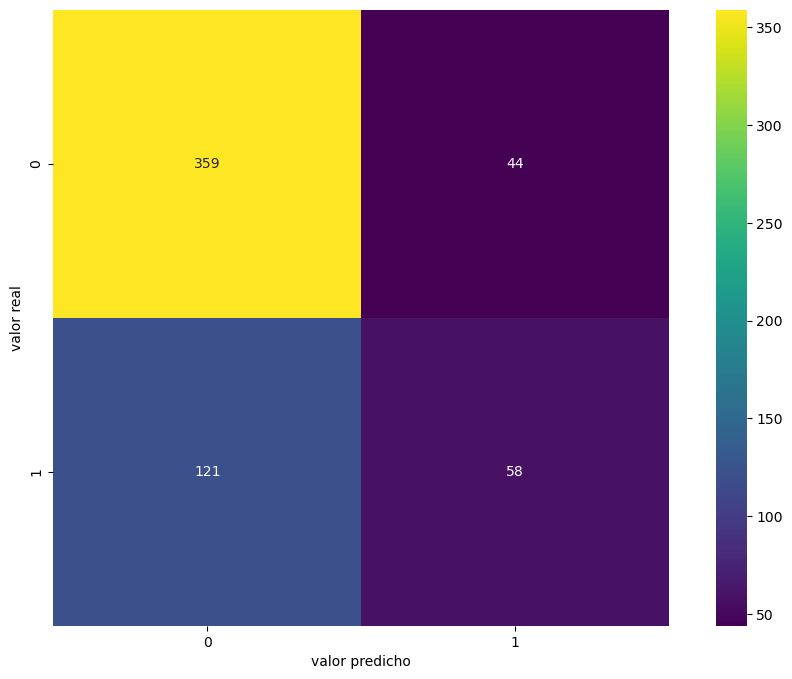

In [102]:
mat_lr1 = confusion_matrix(y_test1, y_pred_test_esta)

plt.figure(figsize = (12, 8))
sns.heatmap(mat_lr1, square=True, annot=True, fmt="d", cmap = "viridis")

plt.xlabel('valor predicho')
plt.ylabel('valor real')
plt.show()

Nos interesa, sobre todo, que no se nos quede fuera ningún verdadero positivo, que es lo que queremos definir, la posibilidad de desarrollar enfermedad en 10 años, en este caso, 58 positivos fueron reales, no se detectaron 121 (falsos negativos). 44 fueron falsos positivos, pero con la actitud proteccionista, no nos preocupa.

In [103]:
# vamos a hacernos una función para sacar las métricas igual que hicimos con al regresión lineal.


def metricas(clases_reales_test, clases_predichas_test, clases_reales_train, clases_predichas_train, modelo):
    
    # para el test
    accuracy_test = accuracy_score(clases_reales_test, clases_predichas_test)
    precision_test = precision_score(clases_reales_test, clases_predichas_test)
    recall_test = recall_score(clases_reales_test, clases_predichas_test)
    f1_test = f1_score(clases_reales_test, clases_predichas_test)
    kappa_test = cohen_kappa_score(clases_reales_test, clases_predichas_test)

    # para el train
    accuracy_train = accuracy_score(clases_reales_train, clases_predichas_train)
    precision_train = precision_score(clases_reales_train, clases_predichas_train)
    recall_train = recall_score(clases_reales_train, clases_predichas_train)
    f1_train = f1_score(clases_reales_train, clases_predichas_train)
    kappa_train = cohen_kappa_score(clases_reales_train, clases_predichas_train)
    

    
    df = pd.DataFrame({"accuracy": [accuracy_test, accuracy_train], 
                       "precision": [precision_test, precision_train],
                       "recall": [recall_test, recall_train], 
                       "f1": [f1_test, f1_train],
                       "kapppa": [kappa_test, kappa_train],
                       "set": ["test", "train"]})
    
    df["modelo"] = modelo
    return df

In [104]:
results_logistic_esta = metricas(y_test1, y_pred_test_esta, y_train1, y_pred_train_esta, "Regresión logistica Balanceada Estandarizada Codificada")
results_logistic_esta

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.716495,0.568627,0.324022,0.412811,0.244013,test,Regresión logistica Balanceada Estandarizada C...
1,0.723322,0.585752,0.313559,0.408464,0.248900,train,Regresión logistica Balanceada Estandarizada C...


---

# Realización del modelo con variable no balanceada

 - estandarizadas y codificadas

In [105]:
# separamos los datos en X e y

X2 = df_est_nobal.drop("TenYearCHD", axis = 1)
y2 = df_est_nobal["TenYearCHD"]

In [106]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.2, random_state = 42)

In [107]:
# definimos la regresión logistica

log_reg = LogisticRegression(n_jobs=-1, max_iter = 1000)

# ajustamos el modelo
log_reg.fit(x_train2,y_train2)

# obtenemos las predicciones para el conjunto de entrenamiento
y_pred_train2 = log_reg_esta.predict(x_train2)

# obtenemos las predicciones para el conjunto de test
y_pred_test2 = log_reg_esta.predict(x_test2)

In [108]:
train_df2 = pd.DataFrame({'Real': y_train2, 'Predicted': y_pred_train2, 'Set': ['Train']*len(y_train2)})
test_df2  = pd.DataFrame({'Real': y_test2,  'Predicted': y_pred_test2,  'Set': ['Test']*len(y_test2)})
resultados2 = pd.concat([train_df2,test_df2], axis = 0)
resultados2.head()

,Real,Predicted,Set
2378,0.0,0.0,Train
3182,0.0,1.0,Train
921,0.0,0.0,Train
2244,0.0,0.0,Train
3131,0.0,0.0,Train


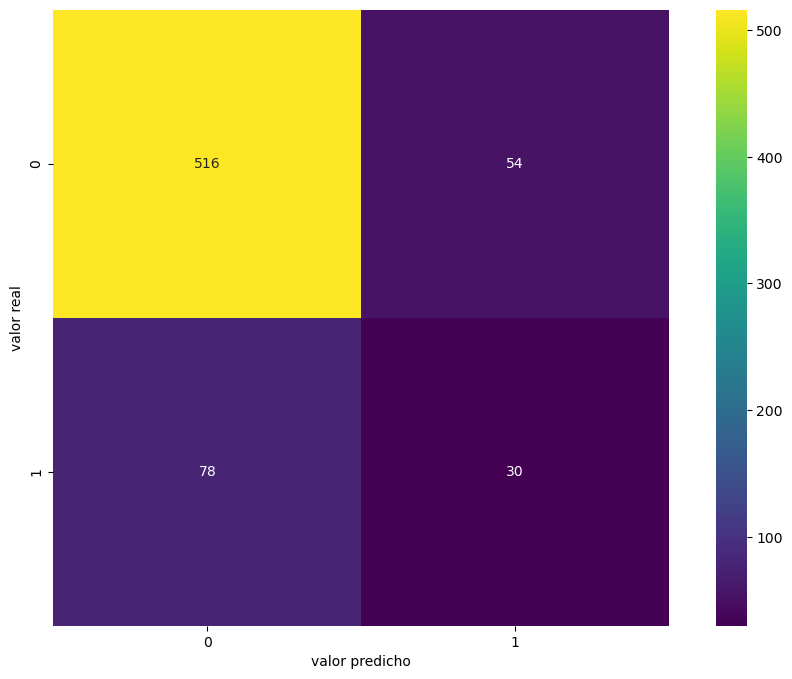

In [109]:
mat_lr2 = confusion_matrix(y_test2, y_pred_test2)

plt.figure(figsize = (12, 8))
sns.heatmap(mat_lr2, square=True, annot=True, fmt="d", cmap = "viridis")

plt.xlabel('valor predicho')
plt.ylabel('valor real')
plt.show()

De los 108 positivos de nuestra muestra, solo nos detecta bien 30. Nos parece muy poco

In [110]:
results_logistic_esta2 = metricas(y_test2, y_pred_test2, y_train2, y_pred_train2, "Regresión logistica Estandarizada Codificada")
results_logistic_esta2

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.805310,0.357143,0.277778,0.312500,0.201157,test,Regresión logistica Estandarizada Codificada
1,0.815265,0.360000,0.312655,0.334661,0.228020,train,Regresión logistica Estandarizada Codificada


---

 - codificadas, no estandarizadas

In [111]:
# separamos los datos en X e y

X3 = df_noesta_nobal.drop("TenYearCHD", axis = 1)
y3 = df_noesta_nobal["TenYearCHD"]

In [112]:
x_train3, x_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size = 0.2, random_state = 42)

In [113]:
X3

,sex,education,age,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,glucose,totChol,sysBP,diaBP,BMI,heartRate
0,1,2.0,64.0,1,3.0,0.0,0.0,0.0,0.0,80.0,221.0,148.0,85.0,26.060925,90.0
1,1,1.0,46.0,1,10.0,0.0,0.0,0.0,0.0,94.0,250.0,116.0,71.0,20.350000,88.0
2,1,1.0,64.0,1,30.0,0.0,0.0,0.0,0.0,77.0,241.0,136.5,85.0,26.420000,70.0
3,0,4.0,36.0,1,35.0,0.0,0.0,0.0,0.0,63.0,295.0,102.0,68.0,28.150000,60.0
4,1,2.0,41.0,1,20.0,0.0,0.0,0.0,0.0,79.0,220.0,126.0,78.0,20.700000,86.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3385,0,4.0,47.0,1,15.0,0.0,0.0,1.0,1.0,183.0,210.0,163.5,97.0,28.240000,105.0
3386,0,1.0,68.0,0,0.0,0.0,0.0,1.0,1.0,120.0,164.0,142.0,85.0,30.280000,70.0
3387,1,1.0,60.0,0,0.0,0.0,0.0,1.0,1.0,78.0,282.0,213.0,94.5,28.580000,71.0
3388,1,1.0,50.0,0,0.0,0.0,0.0,1.0,1.0,260.0,260.0,190.0,130.0,43.670000,85.0


In [114]:
y3

0       1.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3385    0.0
3386    1.0
3387    0.0
3388    0.0
3389    1.0
Name: TenYearCHD, Length: 3390, dtype: category
Categories (2, float64): [0.0, 1.0]

In [115]:
y_test3.astype(int)

134     0
1764    0
2465    0
1987    0
1295    0
       ..
1052    0
759     0
2069    0
3166    1
857     0
Name: TenYearCHD, Length: 678, dtype: int64

In [116]:
# definimos la regresión logistica
log_reg_noesta = LogisticRegression(n_jobs=-1, max_iter = 100000)
# ajustamos el modelo
log_reg_noesta.fit(x_train3,y_train3)
# obtenemos las predicciones para el conjunto de entrenamiento
y_pred_train3 = log_reg_noesta.predict(x_train3)
# obtenemos las predicciones para el conjunto de test
y_pred_test3 = log_reg_noesta.predict(x_test3)

In [117]:
train_df3 = pd.DataFrame({'Real': y_train3, 'Predicted': y_pred_train3, 'Set': ['Train']*len(y_train3)})
test_df3  = pd.DataFrame({'Real': y_test3,  'Predicted': y_pred_test3,  'Set': ['Test']*len(y_test3)})
resultados3 = pd.concat([train_df3,test_df3], axis = 0)
resultados3.head()

,Real,Predicted,Set
2378,0.0,0.0,Train
3182,0.0,0.0,Train
921,0.0,0.0,Train
2244,0.0,0.0,Train
3131,0.0,0.0,Train


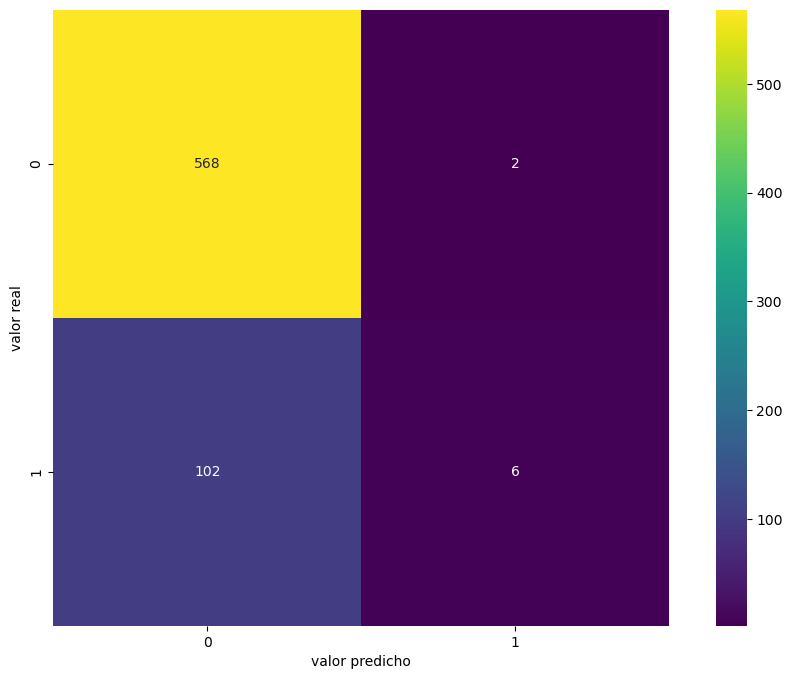

In [118]:
mat_lr3 = confusion_matrix(y_test3, y_pred_test3)

plt.figure(figsize = (12, 8))
sns.heatmap(mat_lr3, square=True, annot=True, fmt="d", cmap = "viridis")

plt.xlabel('valor predicho')
plt.ylabel('valor real')
plt.show()

Este resultado es aún peor que el anterior

In [119]:
results_logistic_esta3 = metricas(y_test3, y_pred_test3, y_train3, y_pred_train3, "Regresión logistica NO Estandarizada Codificada")
results_logistic_esta3

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.846608,0.75000,0.055556,0.103448,0.083307,test,Regresión logistica NO Estandarizada Codificada
1,0.861357,0.77551,0.094293,0.168142,0.140448,train,Regresión logistica NO Estandarizada Codificada


In [120]:
df_concatenados=pd.concat([results_logistic_esta,results_logistic_esta2],axis=0)#results_logistic_esta3

In [121]:
df_final=pd.concat([df_concatenados,results_logistic_esta3],axis=0)
df_final

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.716495,0.568627,0.324022,0.412811,0.244013,test,Regresión logistica Balanceada Estandarizada C...
1,0.723322,0.585752,0.313559,0.408464,0.248900,train,Regresión logistica Balanceada Estandarizada C...
0,0.805310,0.357143,0.277778,0.312500,0.201157,test,Regresión logistica Estandarizada Codificada
1,0.815265,0.360000,0.312655,0.334661,0.228020,train,Regresión logistica Estandarizada Codificada
0,0.846608,0.750000,0.055556,0.103448,0.083307,test,Regresión logistica NO Estandarizada Codificada
1,0.861357,0.775510,0.094293,0.168142,0.140448,train,Regresión logistica NO Estandarizada Codificada


Teniendo en cuenta, la precisión, la capacidad de detectar negativos y positivos, y que kappa en todos los casos es similar, nos quedamos con el primer caso, porque disminuimos la posibilidad de excluir diagnostico positivo a pacientes positivos, pero siempre tenemos que tener en cuenta, que el valor del azar en las predicciones es muy similar en los tres modelos.
De momento, el azar participa en nuestros modelos con mucha importancia, de momento, ninguno de los modelos nos satisface.

In [122]:
df_final.to_pickle('../data-log/04-df_metricas_resultados.pickle')

In [123]:
df_final.to_csv('../data-log/04-df_metricas_resultados.csv')